# A/B design testing

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns
from math import ceil 
from scipy.stats import norm, ttest_ind
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline 

In [2]:
data_frame = pd.read_csv('data.csv')

data = data_frame['data'].values

In [3]:
data.shape

(100,)

## Checking the sample for normal distribution

Let's first look at the distribution of our data. To do this, I plotted the distribution of the data (a graph that looks like a histogram, but it is normalised so that the sum under the curve is 1) and overlaid it with a linear density plot (PDF) of a normal distribution with the mean and standard deviation as in our data.
Does it look like the data is normally distributed?

In [4]:
np.arange(data.min(), data.max(), 0.01)

array([ 4.04330326,  4.05330326,  4.06330326, ..., 33.72330326,
       33.73330326, 33.74330326])

In [5]:
x_axis = np.arange(data.min(), data.max(), 0.01)

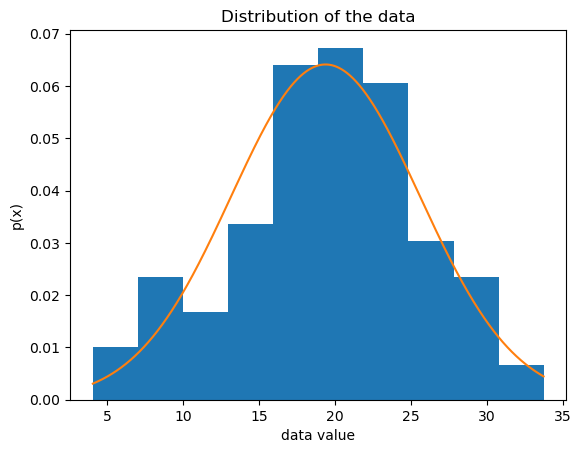

In [6]:
x_axis = np.arange(data.min(), data.max(), 0.01)
plt.hist(data, density=True)
plt.plot(x_axis, norm.pdf(x_axis, data.mean(), data.std()))
plt.xlabel('data value')
plt.ylabel('p(x)')
plt.title('Distribution of the data');

The graph shows that the data distribution is close to a normal distribution.

# QQ plot

Another visualisation method for checking the distribution of a sample of data for normality is the quantile-quantile plot, Q-Q plot or QQ plot.

This graph generates its own sample of an idealised distribution against which we compare our data, in this case the Gaussian distribution. The idealised sample data is divided into groups (e.g. 5) called quantiles. Each point in our data is matched with a similar member from the idealised distribution.

The resulting points are plotted as a scatter plot with the idealised value on the x-axis and the sample data on the y-axis.

If our sample of data perfectly matches the idealised data, it will look like a line of points at a 45-degree angle from the bottom left of the graph to the top right. Often, an additional line is drawn on the graph to help understand this expectation. The deviation of the points from the expectation line (the ideal) shows the deviation of our data from the expected distribution.

We can develop a QQ plot in Python using the [statsmodels qqplot()](https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html). The function takes a sample of data and assumes by default that we are comparing it to a Gaussian distribution.

In [7]:
from statsmodels.graphics.gofplots import qqplot

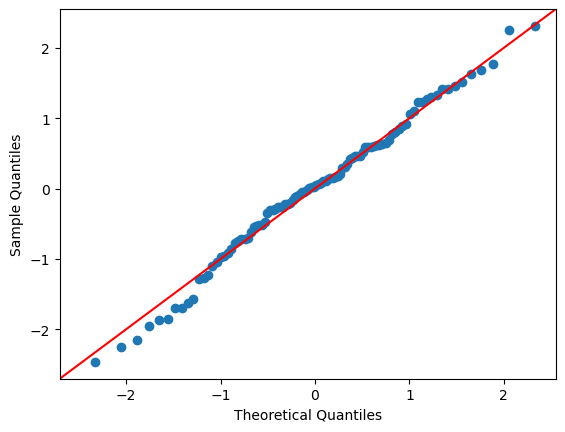

In [8]:
qqplot(data, stats.t, fit=True,line='45')
plt.show()

The linearity of most points suggests that the data are normally distributed.

# A/B testing

Let's imagine that we work on the development team of an online e-commerce business. The UX designer worked very hard on the new version of the product page, hoping that it would lead to a higher conversion rate. According to the Product Manager the current conversion rate averages 13% over the year, and the team will be happy with a 2% increase, meaning that the new design will be considered successful if it raises the conversion rate to 15%.

In [9]:
# Effect size calculation based on our expected rates
effect_size = sms.proportion_effectsize(0.15, 0.13) 
effect_size

0.0576728617308947

In [10]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                             # Calculation of the required sample size

required_n = ceil(required_n)                     # Rounding up to the next whole number                      

print(required_n)

4720


We will need a minimum of 4720 observations for each group.

In [11]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [13]:
# To make sure that the entire control group sees the old page and vice versa.
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


A DataFrame has 294478 rows, each representing a user session, and 5 columns:

   - user_id - user ID of each session
   - timestamp - session timestamp
   - group - to which group the user was assigned for this session {control, treatment}
   - landing_page - what design each user saw in this session {old_page, new_page}
   - convert - whether the session ended with a conversion (binary variable, 0 - no conversion, 1 - there is a conversion)
   
In fact, we will use only the "group" and "convert" columns for analysis.

Before we go ahead and analyze the data to get our subset, let's make sure there are no users who have been selected more than once.

In [14]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users selected more than once.')

There are 3894 users selected more than once.


Since this number is relatively small, we will remove them from the DataFrame to avoid sampling the same users twice.

In [15]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'New dataset size: {df.shape}')

New dataset size: (286690, 5)


In [16]:
# Now our DataFrame is nice and clean, we can go ahead and select n=4720 records for each of the groups.
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [17]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [18]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [19]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

Now we are ready to analyse our results.

In [20]:
# The first thing I did was calculate some basic statistics to get an idea of what our samples looked like.
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x)              # Std. deviation 
se_p = lambda x: stats.sem(x)            # (std / sqrt(n)) - standard error of the mean.

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Judging from the statistics above, our two designs' performance was quite similar, but new design performed slightly better, approximate conversion rate 12.3% vs 12.6%.

It should be noted that the control group's conversion rate is lower than what we would expect based on knowledge of our average conversion rate (12.3% vs 13%). This suggests that there is some variation in the results when selecting a sample from the population.

    So, the value of the treatment group is higher. Is this difference statistically significant?

The last step of our analysis is to test our hypothesis. Since we have a very large sample, we can use a z-test to calculate our value.

In [21]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [22]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% confidence interval for the control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% confidence interval for the treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
95% confidence interval for the control group: [0.114, 0.133]
95% confidence interval for the treatment group: [0.116, 0.135]


# Conclusion

Since our 𝑝 -value = 0.732 is much higher than our 𝛼 = 0.05, we cannot reject the null hypothesis 𝐻0 which means that our new design did not perform significantly (let alone better) than our old one.

In besides, if we look at the confidence interval for the treatment group ([0.116, 0.135], i.e. 11.6-13.5%), we notice that

   - it includes our baseline conversion rate of 13%.
   - It does not include our target value of 15% (the 2% increase we were aiming for).
   
This means that it's more likely that the true conversion rate of the new design will be similar to our baseline, rather than the 15% target we were hoping for. This is further evidence that our new design is unlikely to be an improvement on our old one. So you need to come up with another strategy or leave the design as it is :) 

# A/B game testing

Let's analyse A/B test data in the popular game Cookie Cats. This is a classic match-three puzzle game where the player has to connect tiles of the same colour to clear the board and win the level. The board also features singing cats :)

As players progress through the game, they encounter gates that force them to wait for a while before they can progress or make an in-app purchase. In this block of tasks, I will analyse the results of an A/B test when the first gate in Cookie Cats was moved from level 30 to level 40. In particular, I will analyse the impact on player retention. That is, I want to understand whether moving the gate 10 levels later has somehow affected the fact that users stop playing the game earlier or later in terms of the number of days they have played the game since installing it.

I will work with data from the cookie_cats.csv file. The variables in the data are as follows:

   - userid - a unique number that identifies each player.
   - version - whether the player is in the control group (gate_30 - gate at level 30) or the test group (gate_40 - gate at level 40).
   - sum_gamerounds - the number of game rounds played by the player during the first week after installation
   - retention_1 - did the player come back and start playing 1 day after the installation?
   -  retention_7 - did the player come back and start playing 7 days after the installation?
   
When each player installed the game, he was randomly assigned to either gate_30 or gate_40.

In [23]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [24]:
session_counts = df['userid'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that are found more than once in the dataset.')

There are 0 users that are found more than once in the dataset.


In [25]:
agg_df = df.groupby('version').retention_7.agg(['mean', 'count', 'sum'])

In [26]:
agg_df

,mean,count,sum
version,,,
gate_30,0.190201,44700,8502
gate_40,0.182000,45489,8279


The value of the gate_30 version is slightly higher. Is this difference statistically significant?

H0 - the difference between the two versions in player retention is NOT statistically significant.

In [27]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [28]:
agg_df

,mean,count,sum
version,,,
gate_30,0.190201,44700,8502
gate_40,0.182000,45489,8279


In [29]:
agg_df['sum'].values, agg_df['count'].values

(array([8502, 8279], dtype=int64), array([44700, 45489], dtype=int64))

In [30]:
8502/44700

0.19020134228187918

In [31]:
import statsmodels.stats.api as sms
effect_size = sms.proportion_effectsize(0.19, 0.18) 
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  


In [32]:
required_n

23664.347301915222

In [33]:
z_stat, pval = proportions_ztest(agg_df['sum'].values, nobs=agg_df['count'].values)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(agg_df['sum'], nobs=agg_df['count'], alpha=0.05)

In [34]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% confidence interval for the control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% confidence interval for the treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 3.16
p-value: 0.002
95% confidence interval for the control group: [0.187, 0.194]
95% confidence interval for the treatment group: [0.178, 0.186]


In [35]:
z_stat, pval

(3.164358912748191, 0.001554249975614329)

# Conclusion

Since our 𝑝-value = 0.002 is much smaller than our 𝛼 = 0.05, we reject the null hypothesis 𝐻0 , which means that the difference between user behavior in different versions of the game is statistically significant. So the gate_30 version really gives better retention 7 days after installing the game than the gate_40 version. The confidence intervals of user retention from the two versions of the game do not overlap and it is the gate_40 confidence interval that is lower than the gate_30 confidence interval. This is further evidence that moving the gate from level 30 to level 40 is a bad idea in the context of keeping users in the game longer.

We can also perform Chi Quadrat test at the 5% significance level to determine if there is a relationship between game version and whether a player logs in on day 7 after installing the game. Here the hypotheses are as follows:

    H0: the value of retention_7 does not depend on the version of the game
    H1: there is a dependence between the game version and the retention_7 value

In [36]:
from scipy.stats import chi2_contingency 

In [37]:
observed_values = pd.crosstab(df["version"], df["retention_7"])

In [38]:
observed_values

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [39]:
stats.chi2_contingency(observed_values)

Chi2ContingencyResult(statistic=9.959086799559167, pvalue=0.0016005742679058301, dof=1, expected_freq=array([[36382.90257127,  8317.09742873],
       [37025.09742873,  8463.90257127]]))

   Since our 𝑝-value is much smaller than our 𝛼 = 0.05, we reject the null hypothesis 𝐻0, which means that there is a relationship between the game version and the retention_7 value. Thus, the result is not significantly different from the one we obtained in the z-test.